# Endometrium - alignement to the organoid via Log regression

In [26]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
import os
import sys
from sklearn.linear_model import LogisticRegression

def MovePlots(plotpattern, subplotdir):
    if not os.path.exists(sc.settings.figdir+subplotdir):
        os.makedirs(sc.settings.figdir+subplotdir)
    os.system('mv '+sc.settings.figdir+'*'+plotpattern+'*.* '+sc.settings.figdir+'/'+subplotdir)

    
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_primaryEpithelial_clean/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

scanpy==1.4.4 anndata==0.6.22rc1 umap==0.3.10 numpy==1.17.5 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


'/home/jovyan/my-conda-envs/myenvSC/bin/python'

## Load organoids data

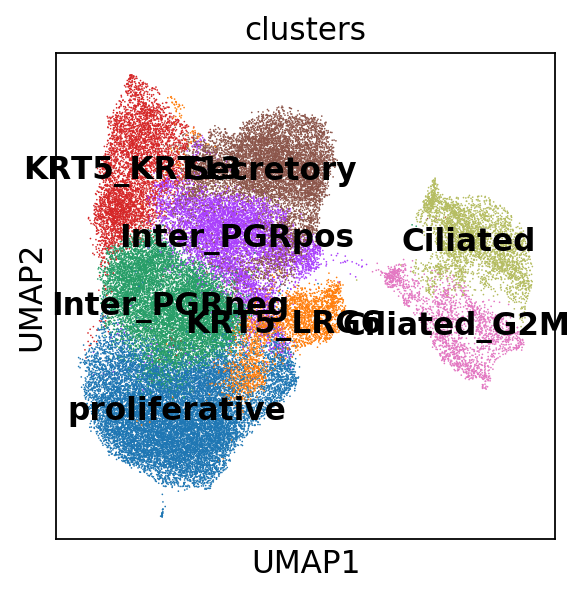

In [27]:
organoid_adataP = sc.read('data/organoids-all-TC-keep-ccg_forSeurat.h5ad')
sc.pl.umap(organoid_adataP, color='clusters', legend_loc='on data')

In [28]:
organoid_adata = organoid_adataP.copy()

In [29]:
sc.pp.filter_genes(organoid_adata, min_cells=5)
sc.pp.normalize_per_cell(organoid_adata, counts_per_cell_after=1e4)
sc.pp.log1p(organoid_adata)
sc.pp.highly_variable_genes(organoid_adata)
highly_variable_genes = organoid_adata.var["highly_variable"]
organoid_adata = organoid_adata[:, highly_variable_genes]
# sc.pp.scale(organoid_adata, max_value=10)

normalizing by total count per cell
    finished (0:00:48): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:02:33)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


## Load all epithelial from primary tissue 

In [30]:
adataP = sc.read('data/epithelial-clean_freeze_annot.h5ad')

In [31]:
adata = anndata.AnnData(X=np.expm1(adataP.raw.X), var=adataP.raw.var, obs=adataP.obs, asview=False)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)#min_mean=0.0125, min_disp=0.25)
highly_variable_genes = adata.var["highly_variable"]
adata = adata[:, highly_variable_genes]
adata.obsm["X_umap"] = adataP.obsm["X_umap"]
# sc.pp.scale(adata, max_value=10)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


### Remove doublets and contaminants

In [32]:
meta = pd.read_csv('data/cell_annotations/endometrium_cellannotation_figure3_epithelialHighRes_20200610.csv')
meta = meta.set_index('index')

Remove barcodes not in meta

In [33]:
barcodes = meta.index.tolist()
adata = adata[[ i in barcodes for i in adata.obs_names]]

## Filter common genes

In [34]:
common_genes = list(set(organoid_adata.var.index.values).intersection(adata.var.index.values))
print('common genes: ', len(common_genes))
adata = adata[:,common_genes]
organoid_adata = organoid_adata[:,common_genes]
print(organoid_adata.X.shape)
print(adata.X.shape)

common genes:  1034
(53720, 1034)
(4998, 1034)


### Build a regression classifier from the organoids

In [35]:
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(organoid_adata.X, [str(i) for i in organoid_adata.obs['clusters'].values])

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=0,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

### Classify





In [36]:
predictions = logisticRegr.predict(adata.X)
adata.obs['predictions'] = predictions
probabilities = logisticRegr.predict_proba(adata.X)
probs_adata = []
for i,clus in enumerate(adata.obs['predictions']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])

Trying to set attribute `.obs` of view, making a copy.


## Plot classification

... storing 'predictions' as categorical


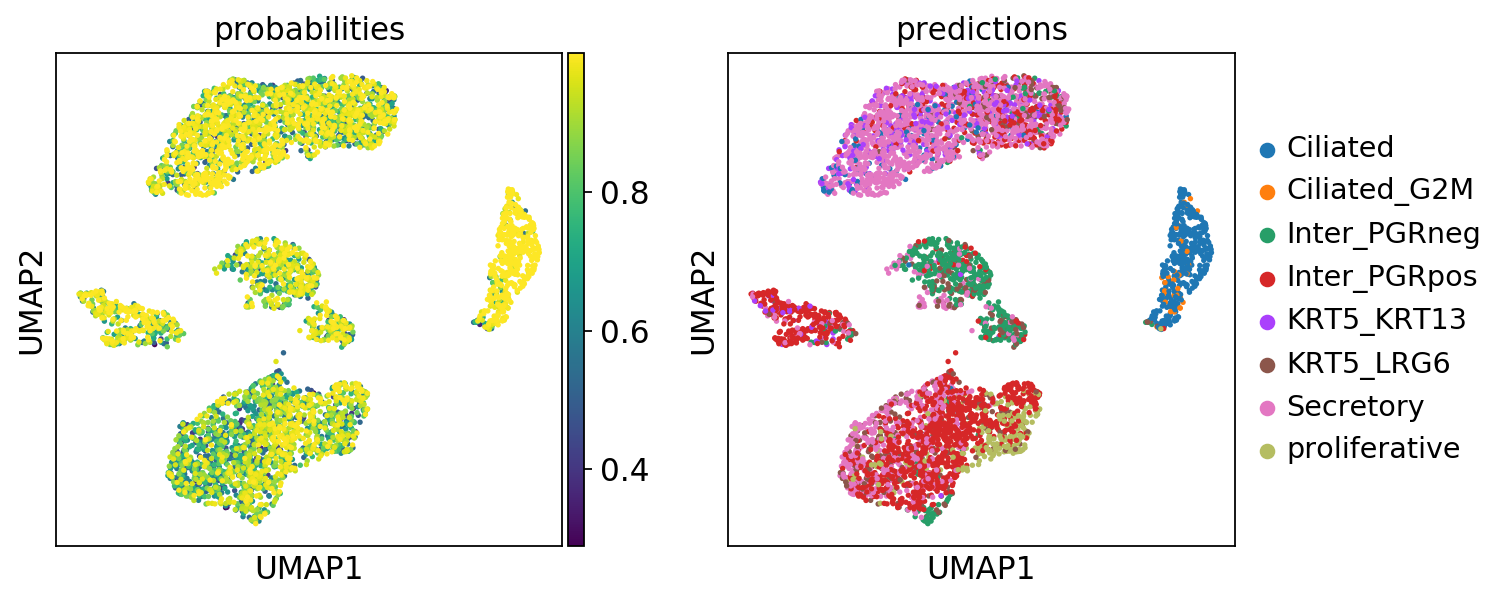

In [37]:
adata.obs['probabilities'] = probs_adata
sc.pl.umap(adata, color=['probabilities',  'predictions'])

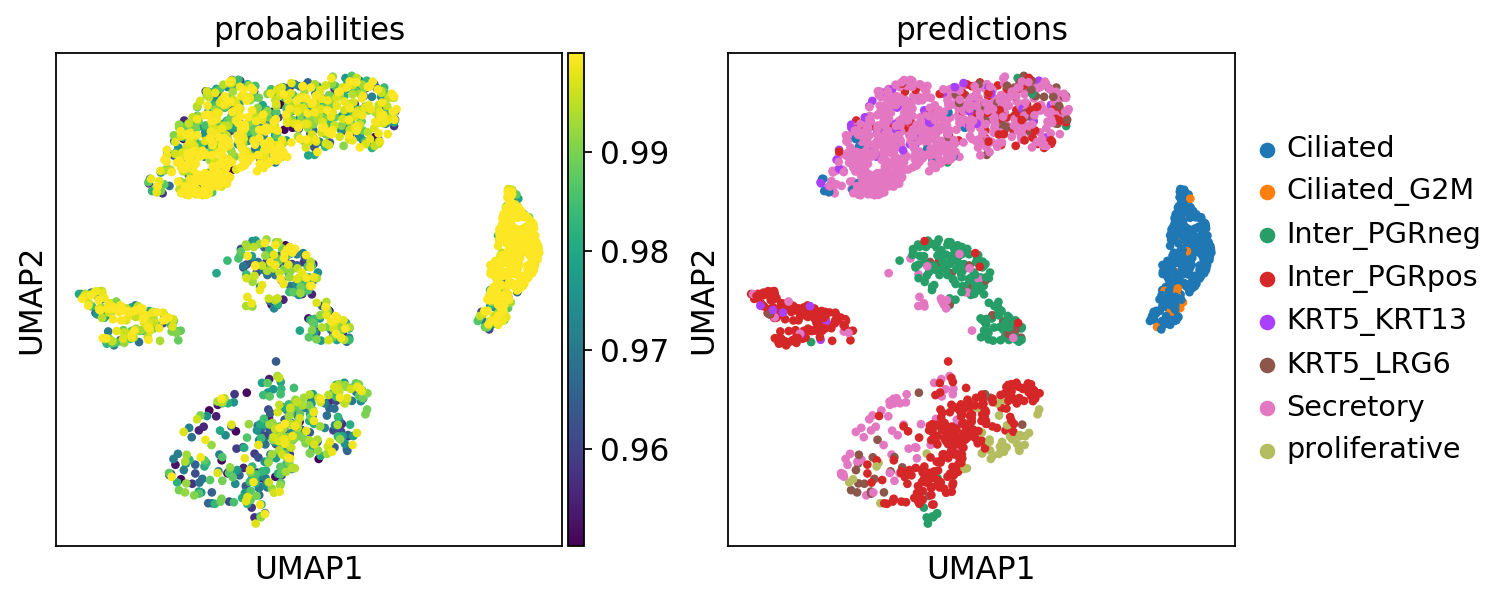

In [38]:
sc.pl.umap(adata[[ i > 0.95 for i in adata.obs['probabilities']  ]], color=['probabilities',  'predictions'])

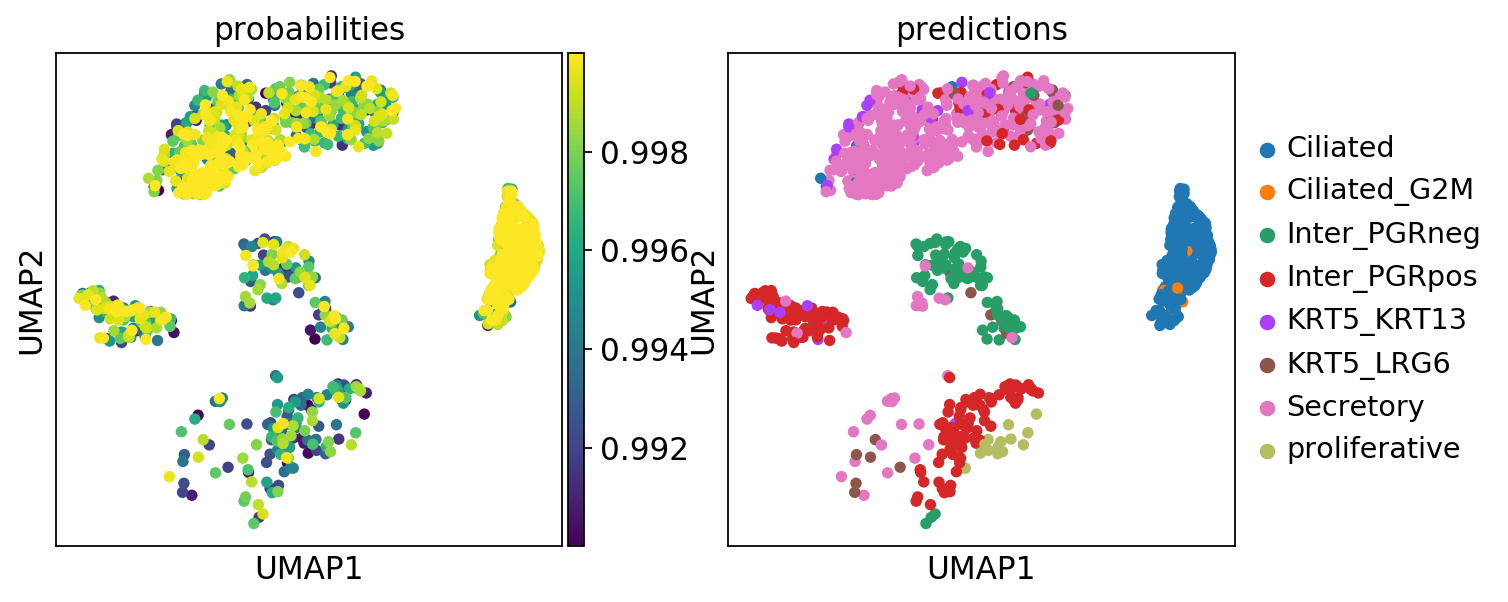

In [39]:
sc.pl.umap(adata[[ i > 0.99 for i in adata.obs['probabilities']  ]], color=['probabilities',  'predictions'])

In [40]:
# # with inhibitors
# adata.obs['predictions'].cat.reorder_categories(['proliferative', 'KRT5_LRG6', 'inter_PGRneg', 'inter', 'KRT5_KRT13', 
#                                               'new_secretory', 'inter_PGRpos', 'glandular_secretory', 'ciliated'], inplace=True)


# import matplotlib.pyplot as pl
# orig_colors = np.array(sc.pl.palettes.zeileis_26)
# new_colors = orig_colors.copy()
# new_colors[[8]] = orig_colors[[6]]
# # new_colors[[8]] = '#a60f22'
# new_colors[[7]] = '#eb054d'
# new_colors[[6]] = '#ffb5b7'
# new_colors[[5]] = '#9e1993'
# new_colors[[4]] = '#de5fad'
# new_colors[[3]] = '#f0dae7'
# new_colors[[2]] = '#ffa8de'
# new_colors[[1]] = '#688a12'
# new_colors[[0]] = '#c2d986'
# adata.uns['predictions_colors'] = new_colors
# sc.pl.umap(adata[[ i > 0.95 for i in adata.obs['probabilities']  ]], color=['probabilities',  'predictions'], save='_predictions_OrganoidwI_lr_HVGs_p95.pdf')
# sc.pl.umap(adata, color=['probabilities',  'predictions'], save='_predictions_OrganoidwI_lr_HVGs.pdf')

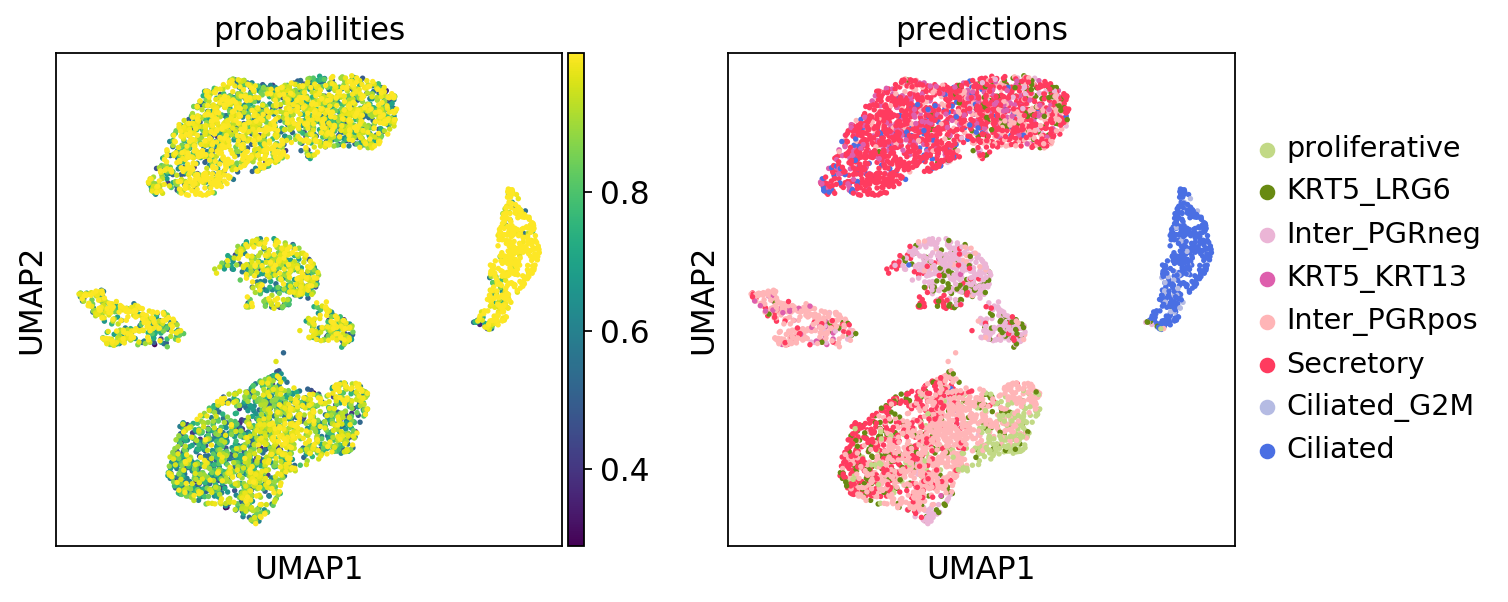

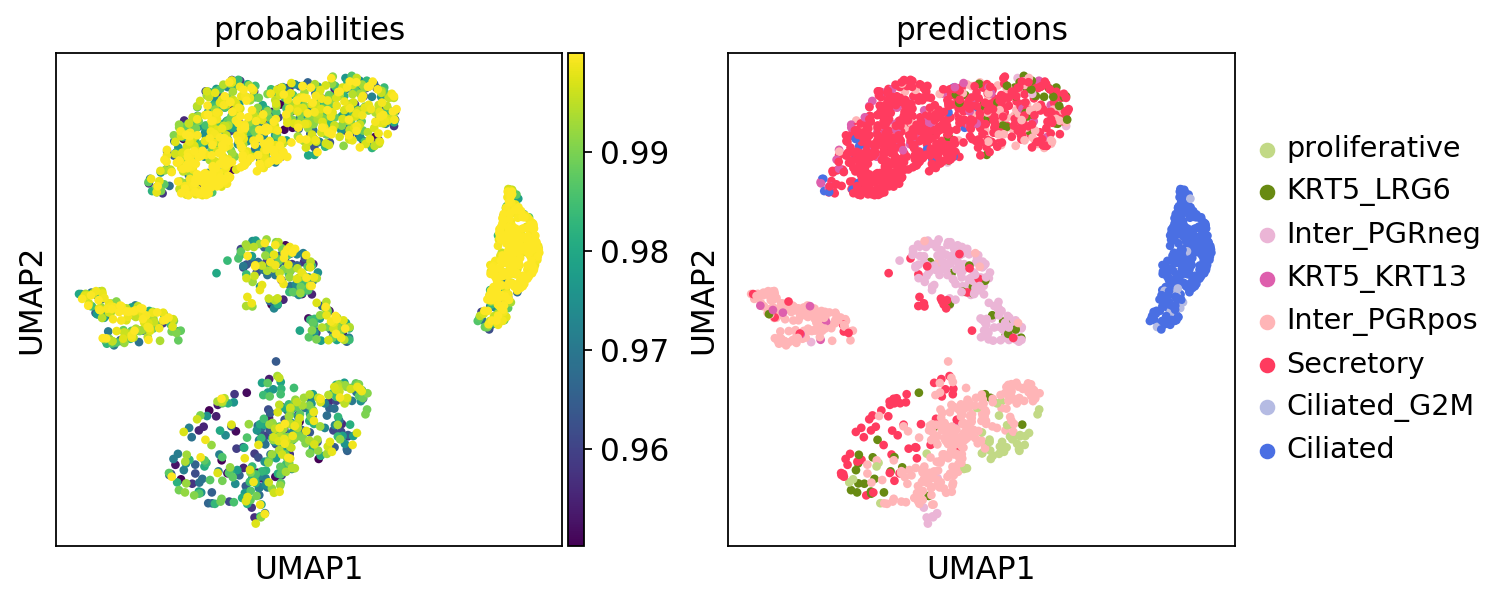

In [41]:
# without inhibitors
adata.obs['predictions'].cat.reorder_categories(['proliferative', 'KRT5_LRG6', 'Inter_PGRneg', 'KRT5_KRT13', 
                                              'Inter_PGRpos', 'Secretory', 
                                              'Ciliated_G2M', 'Ciliated'], inplace=True)

orig_colors = np.array(sc.pl.palettes.zeileis_26)
new_colors = orig_colors.copy()
new_colors[[0, 1, 2, 3, 4, 5, 6, 7, 8]] = orig_colors[[13, 27, 21, 23, 9, 11, 8, 6, 16]]  # mid / red
new_colors[[5]] = '#ff3b5f'
new_colors[[4]] = '#ffb5b7'
new_colors[[3]] = '#de5fad'
new_colors[[2]] = '#ebb5d6'
new_colors[[1]] = '#688a12'
new_colors[[0]] = '#c2d986'
adata.uns['predictions_colors'] = new_colors
sc.pl.umap(adata, color=['probabilities',  'predictions'], save='_predictions_OrganoidNI_lr_HVGs.pdf')
sc.pl.umap(adata[[ i > 0.95 for i in adata.obs['probabilities']  ]], color=['probabilities',  'predictions'], save='_predictions_OrganoidNI_lr_HVGs_p95.pdf')